## Visión por Computadora
## Trabajo Práctico 2

### Integrantes:
- Diego Braga
- Eduardo Echeverria

### Objetivo 1

Implementar un detector de máximo enfoque sobre un video aplicando técnicas de análisis espectral similar al que utilizan las cámaras digitales modernas. El video a procesar será: “focus_video.mov”.

### Objetivo 2

Cambiar la métrica de enfoque eligiendo uno de los algoritmos explicados en el apéndice de: Analysis of focus measure operators in shapefrom focus.

### Estructura del documento

La resolución de todo ejercicio se encuentra integrada en el código a continuación. La idea fue implementar una única función *process_video* que se utilizara para todos los experimentos. Para esto estructuramos el código de forma de tener las implementaciones lo más encapsuladas posibles de forma de poder reutilizar mejor el código.

La técnica implementada para resolver el objetivo 2 fue *Absolute central moment (MIS1)* (apéndice A.1) del paper *"Analysis of focus measure operators in shape-from-focus"* (Said Pertuz, Domenec Puig, Miguel Angel García). Esta técnica se basa en medidas estadísticas del histograma de la imagen, básicamente sumando la diferencias absolutas entre cada uno de sus píxeles y la media ponderadas por su frecuencia relativa.

Cada experimento es acompañado por un gráfico de la métrica para cada frame. En dicho gráfico se marcan en verde los puntos que se consideraron en el rango de máximo enfoque.

In [1]:
# Se importan las librerias necesarias para la resolución del trabajo práctico
import cv2
import numpy as np
from matplotlib import pyplot as plt

#### Implementación del algoritmo "Frequency Domain Image Blur Measure" o FM

In [2]:
def image_quality_measure_FM(frame, debug=False) -> float:
    """
    Métrica FM para una matriz de enfoque compuesta
    por un arreglo de NxM elementos rectangulares equiespaciados.
    
    Parámetros:
        frame (numpy.ndarray): La imagen de entrada en escala de grises.
        debug (boolean): Flag para determinar si se aplican las lineas de código de debug

    Retorno:
        FM (float): La medida de calidad promedio de la imagen (FM).
    """

    # Paso 1: Se calcula F, que es la representación de la Transformada de Fourier de la imagen I
    F = np.fft.fft2(frame)

    if debug:
        print('F.shape = ', F.shape)
    
    # Paso 2: Se obtiene Fc, que se obtiene desplazando F al centro
    Fc = np.fft.fftshift(F)

    if debug:
        print('Fc.shape = ', Fc.shape)
    
    # Paso 3: Se calcula AF = abs(Fc), siendo AF el valor absoluto de la Transformada de Fourier centrada de la imagen I
    AF = np.abs(Fc)

    if debug:
        print('AF.shape = ', AF.shape)
    
    # Paso 4: Se calcula M = max(AF), siendo M el valor máximo del componente de frecuencia en F
    M = np.max(AF)
    
    # Paso 5: Se calcula TH = el número total de píxeles en F cuyo valor de píxel > thres, donde thres = M/1000
    thres = M / 1000
    TH = np.sum(AF > thres)
    
    # Paso 6: Se calcula la medida de calidad de la imagen (FM) a partir de la ecuación presentada en el paper: FM = TH / (M * N)
    FM = TH / (frame.shape[0] * frame.shape[1])

    if debug:
        print('F.shape = ', F.shape)
        print(f"Valor máximo (M): {M}")
        print(f"Umbral (thres): {thres}")
        print(f"Número total de píxeles (TH): {TH}")
        print(f"Tamaño de la imagen (M*N): {frame.shape[0] * frame.shape[1]}")
    
    return FM



#### Implementación del algoritmo "Absolut Central Moment (MIS1)"

In [3]:
def  absolute_central_moment_MIS1(frame, debug=False):
    """
    Absolute central moment (MIS1). Algoritmo del apéndice A.1 del paper 
    "Analysis of focus measure operators in shape-from-focus" (Said Pertuz, Domenec Puig, Miguel Angel García)

    Parámetros:
    frame (numpy.ndarray): La imagen de entrada en escala de grises.
    debug (bool): Si es True, imprime información de depuración.

    Devolver:
    float: Valor de la métrica MIS1.
    """
    
    # Se obtiene el histograma de la imagen
    hist, _ = np.histogram(frame, bins= 256 , range=(0, 256))
    
    # Se calcula la probabilidad para cada nivel de gris
    Pk = hist / np.sum(hist)
    
    # Se calcula la media para la intensidad de los píxeles de la imagen
    m = np.mean(frame)
    
    # Se calcula la métrica
    ACMo = np.sum(np.abs(np.arange(256) - m) * Pk)

    return ACMo

#### Función para realizar el cálculo de la calidad de la imagen para una matriz de enfoque NxM

In [4]:
def measure_over_matrix(frame, n, m, roi_area, metric, spacing=10, debug=False):
    """
    Mide la calidad de la imagen en el dominio de la frecuencia para una matriz de enfoque compuesta
    por un arreglo de NxM elementos rectangulares equiespaciados.
    
    Parámetros:
    frame (numpy.ndarray): La imagen de entrada en escala de grises.
    n (int): Número de elementos en la dirección vertical.
    m (int): Número de elementos en la dirección horizontal.
    spacing (int): Espaciado entre los elementos.

    Retorno:
    float: La medida de calidad promedio de la imagen (FM).
    """
    metric_values = [] # Medidas sobre cada elemento de la matriz

    # Se calcula el área total de la imagen
    frame_area = frame.shape[0] * frame.shape[1]
    frame_height = frame.shape[0]
    frame_width = frame.shape[1]

    # Se calcula el área total de los elementos (según roi_area, ej. si roi_area es 0.1, es el 10% de la imagen)
    total_element_area = roi_area * frame_area

    # Se calcula el tamaño del lado de cada cuadrado
    element_side = int(np.sqrt(total_element_area / (n * m)))

    # Se calcula el tamaño total que ocupará la matriz
    total_matrix_width = m * element_side + (m - 1) * spacing
    total_matrix_height = n * element_side + (n - 1) * spacing

    # Se calculan los márgenes para centrar la cuadrícula en el frame
    start_x = (frame_width - total_matrix_width) // 2
    start_y = (frame_height - total_matrix_height) // 2

    # Se procesa cada uno de los cuadrados de la matriz
    for i in range(n):
        for j in range(m):
            x_start = start_x + j * (element_side + spacing)
            y_start = start_y + i * (element_side + spacing)
            x_end = x_start + element_side
            y_end = y_start + element_side

            # Se valida que el cuadrado no quede fuera del frame
            if x_end < frame_width and y_end < frame_height:
                # Se obtiene la porción de imagen correspondiente
                roi = frame[y_start:y_end, x_start:x_end]
                
                # Se calcula la métrica para el cuadrado
                quality_measure = metric(roi, debug)
                metric_values.append(quality_measure)

    # Se calcula la mediana de las medidas para cada cuadrado
    metric_median = np.median(metric_values)

    return metric_median

#### Función para realizar el dibujado de la matriz NxM

In [5]:
def draw_matrix(frame_rgb, n, m, roi_area, display_color, spacing=10):
    """
    Dado un frame, dibuja una matriz de enfoque y devuelve el resultado.
    
    Parámetros:
    frame_rgb (numpy.ndarray): La imagen de entrada en formato RGB.
    n (int): Número de elementos en la dirección vertical.
    m (int): Número de elementos en la dirección horizontal.
    display_color: Color de la matriz
    spacing (int): Espaciado entre los elementos.

    Retorno:
    numpy.ndarray: Imagen con la matriz dibujada.
    """

    # Se calcula el área total de la imagen
    frame_area = frame_rgb.shape[0] * frame_rgb.shape[1]
    frame_height = frame_rgb.shape[0]
    frame_width = frame_rgb.shape[1]

    # Se calcula el área total de los elementos (según roi_area, ej. si roi_area es 0.1, es el 10% de la imagen)
    total_element_area = roi_area * frame_area

    # Se calcula el tamaño del lado de cada cuadrado
    element_side = int(np.sqrt(total_element_area / (n * m)))

    # Se calcula el tamaño total que ocupará la matriz
    total_matrix_width = m * element_side + (m - 1) * spacing
    total_matrix_height = n * element_side + (n - 1) * spacing

    # Se calculan los márgenes para centrar la cuadrícula en el frame
    start_x = (frame_width - total_matrix_width) // 2
    start_y = (frame_height - total_matrix_height) // 2

    # Se dibujan los cuadrados con el color correspondiente
    for i in range(n):
        for j in range(m):
            x_start = start_x + j * (element_side + spacing)
            y_start = start_y + i * (element_side + spacing)
            x_end = x_start + element_side
            y_end = y_start + element_side

            if x_end < frame_width and y_end < frame_height:
                cv2.rectangle(frame_rgb, (x_start, y_start), (x_end, y_end), display_color, 2)

    return frame_rgb

#### Función que implementa Unsharp Masking

In [6]:
def unsharp_masking(frame, sigma=1.0, definition=5.5, debug=False):
    """
    Aplica unsharp masking a un frame.

    Parámetros:
    frame (numpy.ndarray): La imagen de entrada.
    sigma (float): Desviación estándar para el filtro gaussiano.
    definition (float): Factor que se le aplicará las máscaras (alpha y -beta en addWeighted).

    Retorno:
    numpy.ndarray: La imagen con unsharp masking aplicado.
    """
    
    # Se aplica un filtro gaussiano para suavizar la imagen
    frame_blur = cv2.GaussianBlur(frame, (0, 0), sigma)
    
    # Se crea imagen final restando la imagen suavizada a la imagen original
    img_unsharp_masking = cv2.addWeighted(frame, 1.0 + definition, frame_blur, -definition, 0)
    
    return img_unsharp_masking

#### Función para el procesamiento del video

Esta función también tiene implementado el algoritmo para detectar el punto máximo de enfoque, de forma de marcar en verde en el display el momento en que se alcanza. Se evaluaron dos posibilidades, de las cuales optamos por la segunda:

1) **Realizar la detección de máximo foco en tiempo real.** Si bien realizamos algunas pruebas analizando cambios en la pendiente y máximos parciales de las métricas, los resultados obtenidos fueron algo imprecisos. Es un problema muy interesante que además requiere probar con videos que presenten diferentes variedades de curvas de métricas.

2) **Preprocesar el video y determinar así los fotogramas con enfoque máximo.** Aquí la solución implica leer previamente todo el video y guardar todas las métricas para cada frame para luego, mediante algún criterio, definir cuáles son los que alcanzan el máximo al momento de la reproducción. El criterio elegido fue establecer un umbral dado por un percentil aplicado sobre la lista de métricas guardadas (en principio se estableció en 80). Este valor surge experimentalmente luego de analizar diferentes opciones.

Entre las desventajas de la segunda opción está la demora en el preprocesamiento previo a mostrar el resultado. Esto podría no ser adecuado para videos de mayor duración.

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def process_video(video_path, metric, metric_name='', matrix=None, roi_area=0.1, output_video_path=None, apply_unsharp_masking=False, debug=False, threshold_percentile=80):
    """
    Procesa el video, desplegando las métricas correspondientes.

    Parámetros:
    video_path: Path al video.
    metric: Función de la métrica a utilizar
    metric_name: Nombre de la métrica
    matrix: Tamaño de la matriz de enfoque. Si no se recibe se realiza el cálculo sobre el frame completo
    roi_area: Porcentaje del área del frame que utilizará la matriz de enfoque.
    output_video_path: Ruta donde se guardará el video resultado.
    apply_unsharp_masking: Aplicar unsharp masking?
    debug: Modo debug
    """
    # Primera pasada: se calculan las métricas y se determina el umbral para enfoque

    captura_video = cv2.VideoCapture(video_path)

    if not captura_video.isOpened():
        print("Error al abrir el archivo de video")
        return

    metrics = []

    while True:
        ret, frame = captura_video.read()
        if not ret:
            break

        # Aplica Unsharp Masking en caso que se requiera
        if apply_unsharp_masking:
            frame = unsharp_masking(frame)

        # Se pasa el frame a escala de grises para poder aplicar las métricas de forma más directa
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)        

        # Se realiza el cálculo de la métrica
        if matrix is not None:
            quality_measure = measure_over_matrix(frame_gray, matrix[0], matrix[1], roi_area, metric, debug=debug)
        else:
            quality_measure = metric(frame_gray, debug=debug)

        metrics.append(quality_measure)

    # Se libera el video
    captura_video.release()

    # Se calcula el threshold para el percentil recibido por parámetro (default 85)
    threshold = np.percentile(metrics, threshold_percentile)

    # Segunda pasada: se procesan los frames y se aplican los resultados
    
    captura_video = cv2.VideoCapture(video_path)

    if not captura_video.isOpened():
        print("Error al abrir el archivo de video")
        return

    # Se obtienen las dimensiones de los frames
    frame_width = int(captura_video.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(captura_video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    # Se obtiene frame rate del video
    fps = int(captura_video.get(cv2.CAP_PROP_FPS))
    delay = int(1000 / fps)

    frame_nums = []

    # Inicializa el objeto VideoWriter para guardar el video
    if output_video_path is not None:
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

    paused = False
    i = 0

    while True:
        ret, frame = captura_video.read()
        if not ret:
            break

        # Se obtiene el número del frame actual
        frame_num = captura_video.get(cv2.CAP_PROP_POS_FRAMES)

        quality_measure = metrics[i]
        i += 1

        if apply_unsharp_masking:
            frame = unsharp_masking(frame)

        # Por defecto el color de los elementos del frame es rojo, y en caso de superar el umbral de enfoque pasa a verde
        display_color = (0, 0, 255)
        if quality_measure >= threshold:
            display_color = (0, 255, 0)
            
            # Si no hay una matriz de enfoque, entonces se dibuja un cuadro verde alrededor del frame
            if matrix is None:
                cv2.rectangle(frame, (0, 0), (frame_width - 1, frame_height - 1), display_color, 2)

        # Se muestra la mediana de la métrica en el video (informativo)
        cv2.putText(frame, f"Metrica {metric_name}: {quality_measure:.2f}", (10, frame_height - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, display_color, 1)
        
        # Si se indicó una matriz entonces se muestra en el color correspondiente
        if matrix is not None:
            frame = draw_matrix(frame, matrix[0], matrix[1], roi_area, display_color)

        # Se muestra el frame con los datos estampados
        cv2.imshow('Video con matriz de enfoque', frame)

        # Se escribe el frame en el archivo de salida de video (opcional)
        if output_video_path is not None:
            out.write(frame)

        frame_nums.append(frame_num)

        # Con q se finaliza la visualización y con espacio se pausa
        key = cv2.waitKey(delay if not paused else 0) & 0xFF
        if key == ord('q'):
            break
        elif key == ord(' '):
            paused = not paused

    # Se libera el video
    captura_video.release()

    if key != ord('q'):
        # Se grafica número de frame vs medida de la métrica
        plt.figure()
        #plt.plot(frame_nums, metrics, marker='o', linestyle='-', color='b')
        colors = ['g' if m >= threshold else 'b' for m in metrics]
        plt.scatter(frame_nums, metrics, c=colors)
        plt.xlabel('#Frame')
        plt.ylabel(f'Métrica {metric_name}')
        plt.title(f'Métrica {metric_name} vs #Frame')
        plt.grid(True)
        plt.show()

    # Se cierra el archivo de salida y se cierra todas las ventanas de esta ejecución
    if output_video_path is not None:
        out.release()
    cv2.destroyAllWindows()


### Objetivo 1 - Implementación de la métrica en base al algoritmo "Frequency Domain Image Blur Measure" o FM

#### Experimento 1.1 - Medición sobre el frame completo

Métrica de medición: FM

ROI: 100% (Frame completo)

Unsharp Masking: Desactivado

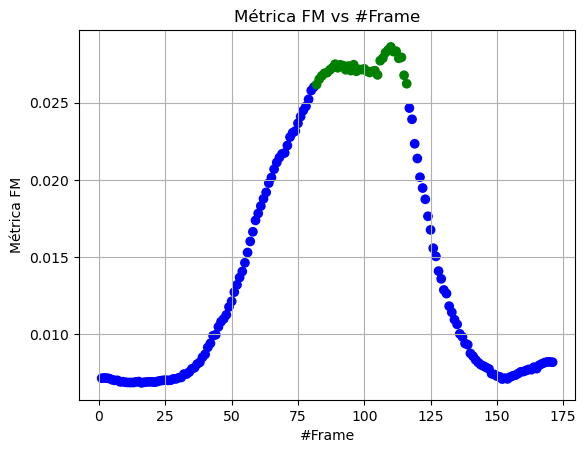

In [8]:
process_video('focus_video.mov', output_video_path='./Experimentos/FM_frame_completo.mov', metric=image_quality_measure_FM, metric_name='FM', apply_unsharp_masking=False)

### Experimento 1.2 - Medición sobre un ROI del 10%

Métrica de medición: FM

ROI: 10%

Unsharp Masking: Desactivado


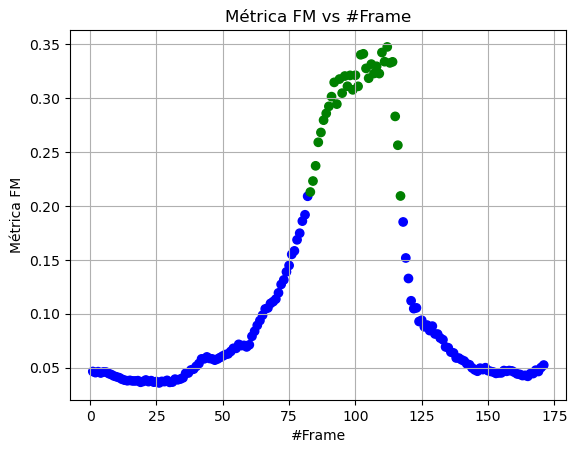

In [9]:
process_video('focus_video.mov', matrix=(1,1), output_video_path='Experimentos/FM_matriz_1x1.mov', metric=image_quality_measure_FM, metric_name='FM', apply_unsharp_masking=False)

### Experimento 1.3 - Medición sobre una Matriz de Enfoque

#### Experimento 1.3a

Métrica de medición: FM

Matriz de enfoque: 3 x 3

Unsharp Masking: Desactivado

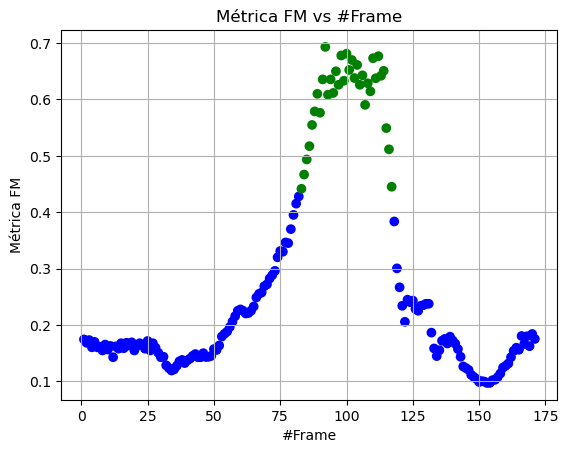

In [10]:
process_video('focus_video.mov', matrix=(3,3), output_video_path='Experimentos/FM_matriz_3x3.mov', metric=image_quality_measure_FM, metric_name='FM', apply_unsharp_masking=False)

#### Experimento 1.3b

Métrica de medición: FM

Matriz de enfoque: 7 x 5

Unsharp Masking: Desactivado

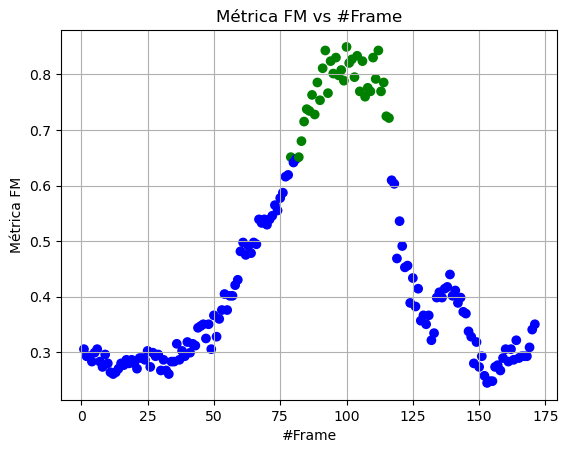

In [11]:
process_video('focus_video.mov', matrix=(7,5), output_video_path='Experimentos/FM_matriz_7x5.mov', metric=image_quality_measure_FM, metric_name='FM', apply_unsharp_masking=False)

#### Experimento 1.3c

Métrica de medición: FM

Matriz de enfoque: 7 x 7

Unsharp Masking: Desactivado

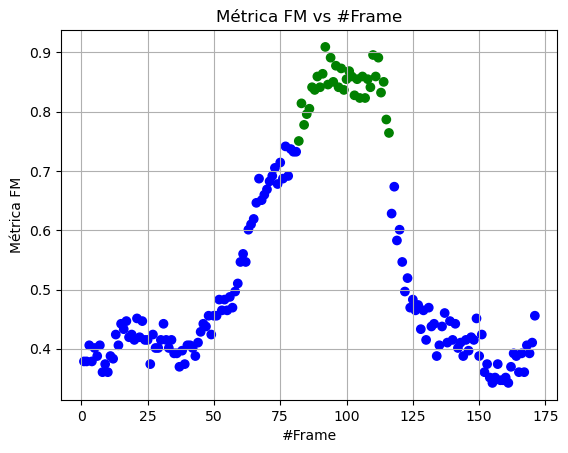

In [12]:
process_video('focus_video.mov', matrix=(7,7), output_video_path='Experimentos/FM_matriz_7x7.mov', metric=image_quality_measure_FM, metric_name='FM', apply_unsharp_masking=False)

#### Experimento 1.3d

Métrica de medición: FM

Matriz de enfoque: 10 x 10

Unsharp Masking: Desactivado

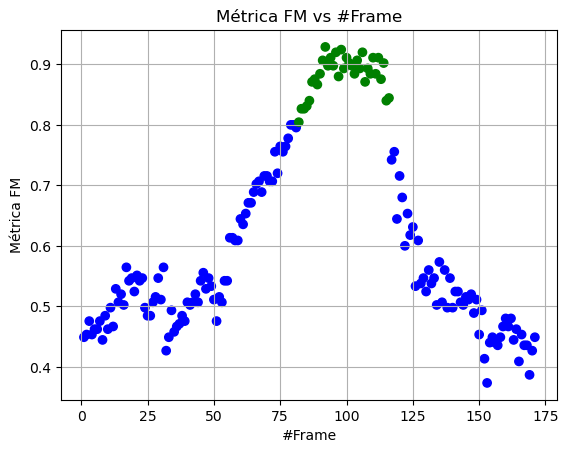

In [13]:
process_video('focus_video.mov', matrix=(10,10), output_video_path='Experimentos/FM_matriz_10x10.mov', metric=image_quality_measure_FM, metric_name='FM', apply_unsharp_masking=False)

### Objetivo 2 - Implementar métrica en base al algoritmo "Absolut Central Moment (MIS1)"

#### Experimento 2.1 - Medición sobre el frame completo

Métrica de medición: MIS1

ROI: 100% (Frame Completo)

Unsharp Masking: Desactivado

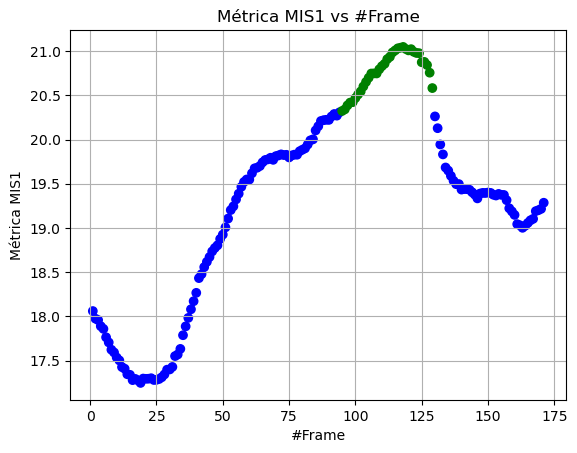

In [14]:
process_video('focus_video.mov', output_video_path='Experimentos/MIS1_frame_completo.mov', metric=absolute_central_moment_MIS1, metric_name='MIS1', apply_unsharp_masking=False)

#### Experimento 2.2 - Medición sobre una Matriz de Enfoque

##### Experimento 2.2a

Métrica de medición: MIS1

Matriz de enfoque: 1 x 1

Unsharp Masking: Desactivado

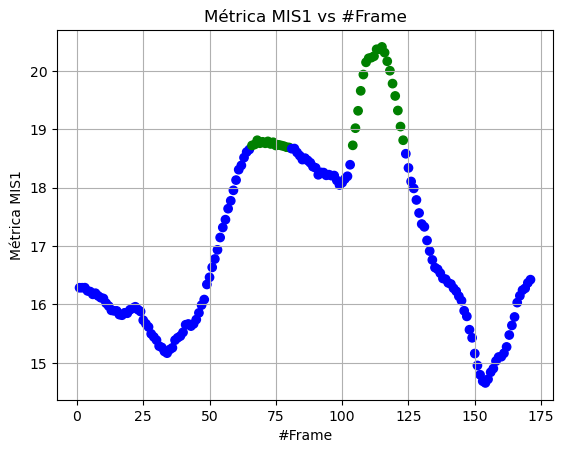

In [15]:
process_video('focus_video.mov', matrix=(1,1), output_video_path='Experimentos/MIS1_matriz_1x1.mov', metric=absolute_central_moment_MIS1, metric_name='MIS1', apply_unsharp_masking=False)

##### Experimento 2.2b

Métrica de medición: MIS1

Matriz de enfoque: 3 x 3

Unsharp Masking: Desactivado

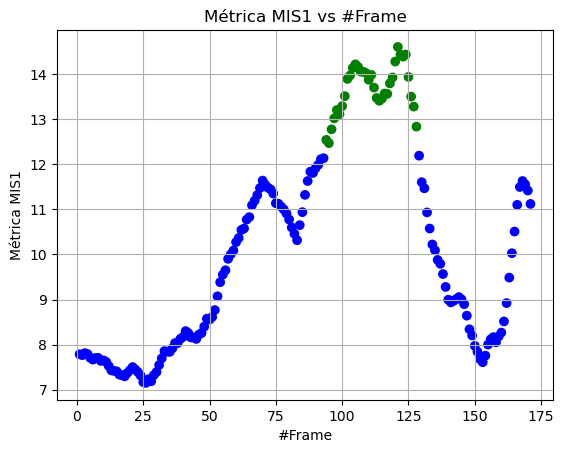

In [16]:
process_video('focus_video.mov', matrix=(3,3), output_video_path='Experimentos/MIS1_matriz_3x3.mov', metric=absolute_central_moment_MIS1, metric_name='MIS1', apply_unsharp_masking=False)

##### Experimento 2.2c

Métrica de medición: MIS1

Matriz de enfoque: 7 x 5

Unsharp Masking: Desactivado

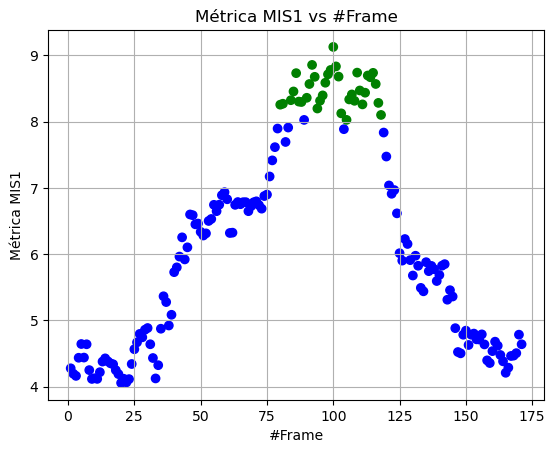

In [17]:
process_video('focus_video.mov', matrix=(7,5), output_video_path='Experimentos/MIS1_matriz_7x5.mov', metric=absolute_central_moment_MIS1, metric_name='MIS1', apply_unsharp_masking=False)

##### Experimento 2.2d

Métrica de medición: MIS1

Matriz de enfoque: 7 x 7

Unsharp Masking: Desactivado

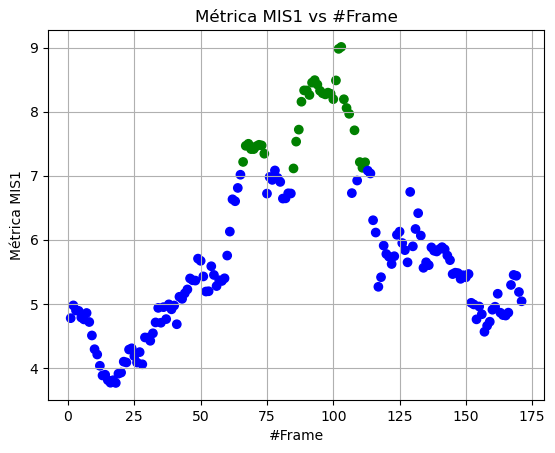

In [18]:
process_video('focus_video.mov', matrix=(7,7), output_video_path='Experimentos/MIS1_matriz_7x7.mov', metric=absolute_central_moment_MIS1, metric_name='MIS1', apply_unsharp_masking=False)

### Ejemplos con Unsharp Masking

A continuación se presentan dos ejemplos aplicando Unsharp Masking para los dos algoritmos implementados. En ambos casos se tomará una matriz de tamaño 3x3, pero es posible variar los parámetros para analizar el comportamiento con diferentes dimensiones. En particular no se notaron grandes cambios en el tiempo en que se permanece en el área de máximo enfoque. Esto se debe a que el algoritmo implementado toma el percentil de las métricas de todos los frames y el algoritmo unsharp masking también se aplica a todos.

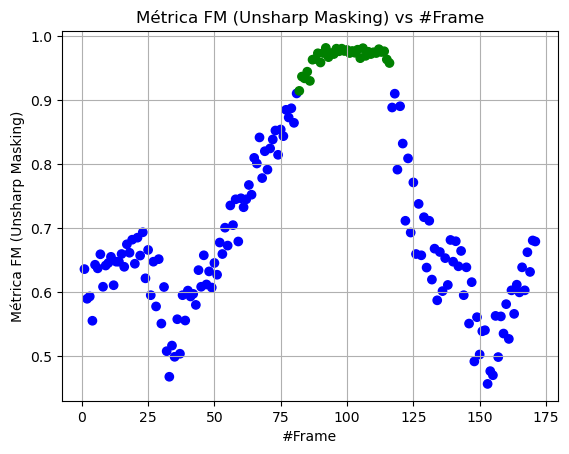

In [19]:
process_video('focus_video.mov', matrix=(3,3), output_video_path='Experimentos/um_FM_matriz_3x3.mov', metric=image_quality_measure_FM, metric_name='FM (Unsharp Masking)', apply_unsharp_masking=True)

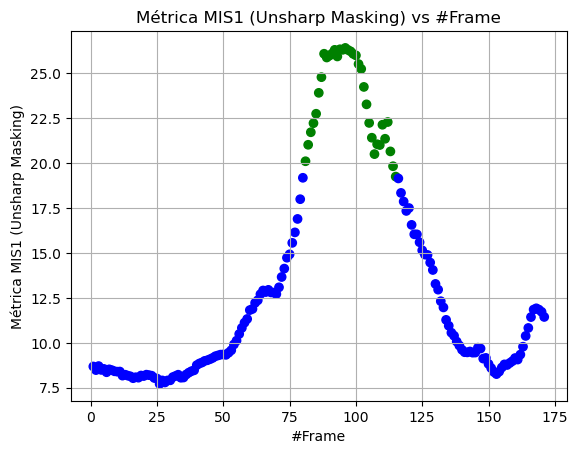

In [20]:
process_video('focus_video.mov', matrix=(3,3), output_video_path='Experimentos/um_MIS1_matriz_3x3.mov', metric=absolute_central_moment_MIS1, metric_name='MIS1 (Unsharp Masking)', apply_unsharp_masking=True)

### Observaciones generales de los experimentos

Analizando el resultado de los experimentos se observó que utilizando la técnica del objetivo 1 (del paper *"Image
Sharpness Measure for Blurred Images in Frequency Domain"*) se obtuvieron resultados más estables que con la segunda (MIS1). Esto puede deberse a que la primera (FM), se basa en la información extraída de la transformada de Fourier, que tiene capacidad de captar mejor elementos de alta frecuencia como bordes y detalles que son, en definitiva, los que mejor determinan que una imagen esté enfocada o no. Por otro lado, "MIS1" utiliza como base el histograma de la imagen cuya información no proporciona tantos detalles como la FFT y los detalles finos como los bordes no son tan evidentes.

Luego, la aplicación de Unsharp Masking provoca un incremento de las métricas. Esto es debido a que dicho algoritmo aumenta la nitidez de los frames resaltando bordes y detalles finos, lo cual realza las frecuencias altas para FM, como también por las diferencias de contraste para MIS1.